## Image postprocessing

This example shows how to:
   - setup and apply 2D postprocessing algorithms
   - display and live update histogram of the raytracing output

In [1]:
# use "qt" option to open figures outside the browser, this saves scrolling to see
# results after running cells on the other end of the notebook
%matplotlib qt

# use "notebook" option to display figures between cells
#%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from plotoptix import NpOptiX

Make some data first:

In [2]:
def f(x, z): return np.sqrt(x ** 2 + z ** 2)

rx = (-1, 1.8)
rz = (-1, 1.8)
n = 18

x = np.linspace(rx[0], rx[1], n)
z = np.linspace(rz[0], rz[1], n)

X, Z = np.meshgrid(x, z)
Y = f(X, Z)

# positions of blocks:
data = np.stack((X.flatten(), np.zeros(n*n), Z.flatten())).T
# height of blocks in Y direction:
v = np.zeros(data.shape); v[:,1] = (Y.flatten() + 0.3 * np.random.rand(n*n))[:]
# X and Z sizes of blocks:
size_u = 0.98 * (rx[1] - rx[0]) / (n - 1)
size_w = 0.98 * (rz[1] - rz[0]) / (n - 1)

Prepare the figure:

<IPython.core.display.Javascript object>


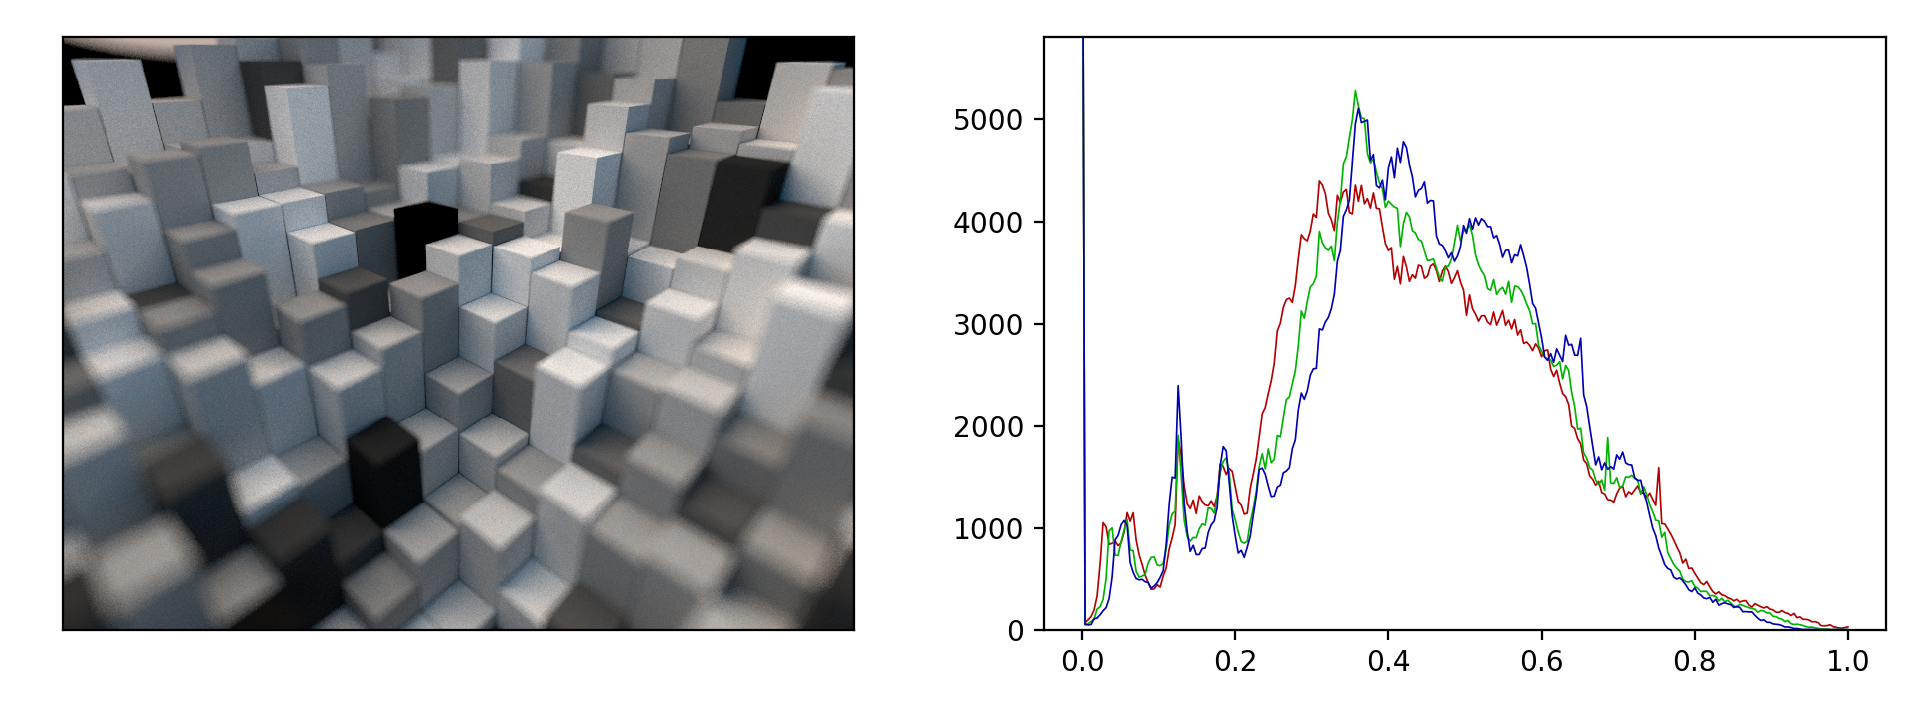

In [3]:
width = 800; height = 600 # ray tracing output size in pixels

im0 = np.zeros((height, width, 4), dtype=np.uint8)

fig = plt.figure(1, figsize=(9.5, 3.5))

ax_img = fig.add_subplot(1,2,1)
data_img = ax_img.imshow(im0)

plt.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False,
                labelbottom=False, labelleft=False)
ax_hist = fig.add_subplot(1,2,2)
steps = np.linspace(0, 1, 256)
hr = np.bincount(im0[:,:,0].flatten(), minlength=256)
data_hr, = ax_hist.plot(steps, hr, color=(0.7, 0, 0), linewidth=0.6)
hg = np.bincount(im0[:,:,1].flatten(), minlength=256)
data_hg, = ax_hist.plot(steps, hg, color=(0, 0.7, 0), linewidth=0.6)
hb = np.bincount(im0[:,:,2].flatten(), minlength=256)
data_hb, = ax_hist.plot(steps, hb, color=(0, 0, 0.7), linewidth=0.6)

plt.tight_layout()
plt.show()

Callback function updating the image and RGB histograms:

In [4]:
def update_image(rt: NpOptiX) -> None:
    data_img.set_data(rt._img_rgba)
    hr = np.bincount(rt._img_rgba[:,:,0].flatten(), minlength=256)
    data_hr.set_ydata(hr)
    hg = np.bincount(rt._img_rgba[:,:,1].flatten(), minlength=256)
    data_hg.set_ydata(hg)
    hb = np.bincount(rt._img_rgba[:,:,2].flatten(), minlength=256)
    data_hb.set_ydata(hb)
    ax_hist.set_ylim(0, 1.1 * np.max([np.max(hr[1:-1]), np.max(hg[1:-1]), np.max(hb[1:-1])]))
    plt.draw()

Configure `NpOptiX` raytracer:

In [5]:
optix = NpOptiX(on_launch_finished=update_image, width=width, height=height, start_now=False)

In [6]:
optix.set_param(max_accumulation_frames=50)  # accumulate up tp 50 frames
optix.set_background(0)                      # black background
optix.set_ambient([0, 0.2, 0.4])             # cold ambient light

In [7]:
# camera parameters:
optix.setup_camera("cam1", cam_type="DoF",
                   eye=[-0.3, 2, -0.3], target=[1, 1, 1], fov=60, focal_scale=0.85)
# warm spherical light:
optix.setup_light("light1", pos=[3, 4.5, 1], color=[6, 5, 4.5], radius=2)

Add plot geometry:

In [8]:
optix.set_data("blocks", pos=data, u=[size_u, 0, 0], v=v, w=[0, 0, size_w],
               c = np.random.rand(n*n), geom="Parallelepipeds")

Start raytracing. Image and histograms should appear in the figure. Image is a bit dark with some burned spots, histogram is quite lef-shifted, and has under/overflows.

In [9]:
optix.start()

#### Perfecting the image.
Each algorithm has its own parameters which should be configured before adding the postprocessing stage. Set parameter values and call `add_postproc()` once. Algorithms can be re-configured simply by changing parameter values. See [postprocessing docs](https://plotoptix.rnd.team/npoptix_config.html#postprocessing-2d) for other algorithms description. See also postprocessing code in basic examples.

---
**Levels adjusment:** image values are shifted and scaled linearly to fit provided low / high range into the destination range of <0;1>; small negative low range should largely eliminate underflow visible in the histogram at 0.

In [10]:
optix.set_float("levels_low_range", -0.01, -0.01, -0.01) # low R, G, B 
optix.set_float("levels_high_range", 1, 1, 1) # high R, G, B
optix.add_postproc("Levels", refresh=True)

**Tonal correction:** image values are scaled by `exposure` value and modified according to the correction curve; `np.sqrt` will boost shadows here; `exposure` lowers amount of burned whites visible on the histogram at 1.

In [11]:
optix.set_float("tonemap_exposure", 0.9)
optix.set_texture_1d("tone_curve_gray", np.sqrt(np.linspace(0, 1, 64)))
optix.add_postproc("GrayCurve", refresh=True)

**Re-configuration:** run cells below and find best parameters.

In [12]:
optix.set_float("tonemap_exposure", 0.75)
optix.set_texture_1d("tone_curve_gray", np.sqrt(np.linspace(0, 1, 64)), refresh=True)

In [13]:
optix.set_float("levels_low_range", -0.05, -0.02, -0.01) # simple sepia-tone
optix.set_float("levels_high_range", 1, 1, 1, refresh=True)

Light position, color and size affects the image as well, of course, so try changing the lighting:

In [14]:
# use warmer color, make softer light with a larger radius
optix.update_light("light1", pos=[3, 4.5, 1], color=[6, 5, 4], radius=2.5)

Stop raytracing (does not close the figure).

In [15]:
optix.close()